In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  
import h5py
import numpy as np
import keras
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.special import expit
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.utils import multi_gpu_model
import tensorflow as tf

Using TensorFlow backend.


In [2]:
input_img=Input(shape= (40, 40, 1))
layer=input_img
layer=Conv2D(128, kernel_size=(3, 3),activation='relu',padding='same')(layer)
layer=MaxPooling2D(pool_size=(2, 2),padding='same')(layer)
layer=Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(layer)
layer=MaxPooling2D(pool_size=(2, 2),padding='same')(layer)
layer=Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(layer)

layer=Flatten()(layer)
layer=Dense(32, activation='relu')(layer)
layer=Dense(6, activation='relu')(layer)
layer=Dense(1, activation='sigmoid')(layer)

model=Model(input_img ,layer)
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
model.summary()
#model.load_weights(".h5")
model.save_weights('cnnbase.h5')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
flat

In [70]:
# Not all NN model can benefit from the keras parallel (https://github.com/keras-team/keras/issues/9204)

GPU = 2
if GPU > 1:
    # Multi-GPU 
    parallel_model = multi_gpu_model(model, gpus=2)
    parallel_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
    parallel_model.save_weights('parallel_cnnbase.h5')

In [3]:
f = h5py.File('/pub/daohangt/hep/data/all_118370.h5','r')
ee_x = f['features']['Ecal_E'][:]
et_x = f['features']['Ecal_ET'][:]
he_x = f['features']['Hcal_E'][:]
ht_x = f['features']['Hcal_ET'][:]
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

(236740, 31, 31)
(236740, 31, 31)
(236740, 32, 32)
(236740, 32, 32)


In [4]:
ee_y = f['targets']['Ecal_E'][:]
et_y = f['targets']['Ecal_ET'][:]
he_y = f['targets']['Hcal_E'][:]
ht_y = f['targets']['Hcal_ET'][:]
print(ee_y.shape)
print(et_y.shape)
print(he_y.shape)
print(ht_y.shape)

(236740,)
(236740,)
(236740,)
(236740,)


In [5]:
# Separate bg/sig for visualizing the jet images
ee_i_bg, ee_i_sig = np.where(ee_y == 0)[0], np.where(ee_y == 1)[0]
ee_x_bg = ee_x[ee_i_bg]
ee_x_sig = ee_x[ee_i_sig]

et_i_bg, et_i_sig = np.where(et_y == 0)[0], np.where(et_y == 1)[0]
et_x_bg = et_x[et_i_bg]
et_x_sig = et_x[et_i_sig]

he_i_bg, he_i_sig = np.where(he_y == 0)[0], np.where(he_y == 1)[0]
he_x_bg = he_x[he_i_bg]
he_x_sig = he_x[he_i_sig]

ht_i_bg, ht_i_sig = np.where(ht_y == 0)[0], np.where(ht_y == 1)[0]
ht_x_bg = ht_x[ht_i_bg]
ht_x_sig = ht_x[ht_i_sig]

In [6]:
# Visualize the bg and sig jet images
def plot2(a,b,vmax,name,ta,tb):
    fig = plt.figure(figsize=(10, 10))
    row,col=1,2
    ax1 = fig.add_subplot(row,col,1)
    plt.imshow(a,cmap='Blues',vmin=-10,vmax=vmax)
    ax2 = fig.add_subplot(row,col,2)
    plt.imshow(b,cmap='Reds',vmin=-10,vmax=vmax)
    #plt.show()
    ax1.title.set_text(ta)
    ax2.title.set_text(tb)
    plt.savefig(name)
    
def plot2_nAgg(s,e,xbg,xsig,vmax,name,ta,tb):
    if len(xbg.shape) == 3:
        xbgg = np.copy(xbg[0])
        xsigg = np.copy(xsig[0])
        for i in range(s,e):
            xbgg += xbg[i]
            xsigg += xsig[i]
    else:
        xbgg = np.copy(xbg[0][0])
        xsigg = np.copy(xsig[0][0])
        for i in range(s,e):
            xbgg += xbg[i][0]
            xsigg += xsig[i][0]
    plot2(xbgg,xsigg,vmax,name,ta,tb)

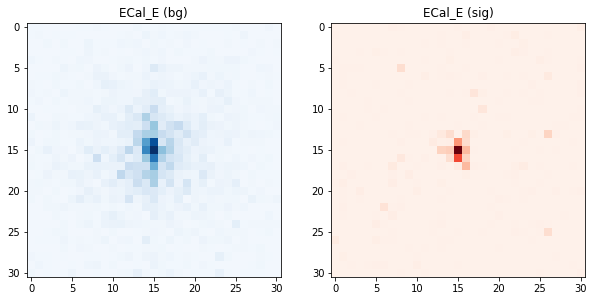

In [7]:
plot2_nAgg(0,1000,ee_x_bg,ee_x_sig,400,"ee.png",'ECal_E (bg)','ECal_E (sig)')

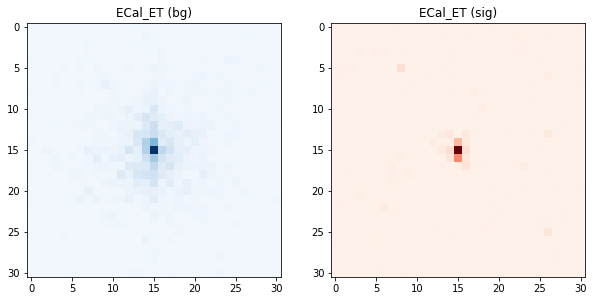

In [8]:
plot2_nAgg(0,1000,et_x_bg,et_x_sig,400,"et.png",'ECal_ET (bg)','ECal_ET (sig)')

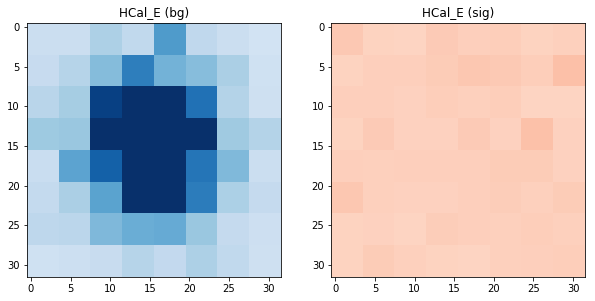

In [9]:
plot2_nAgg(0,1000,he_x_bg,he_x_sig,50,"he.png",'HCal_E (bg)','HCal_E (sig)')

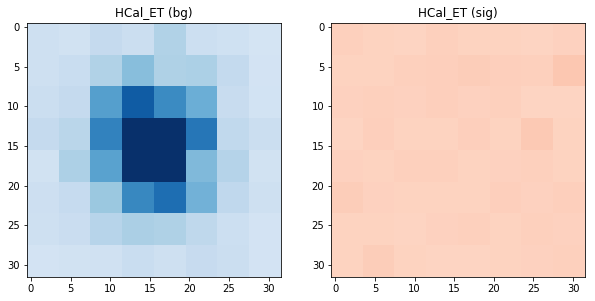

In [10]:
plot2_nAgg(0,1000,ht_x_bg,ht_x_sig,50,"ht.png",'HCal_ET (bg)','HCal_ET (sig)')

In [5]:
print("Before massaging: ")
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

def pad(x):
    if x.shape[-1] == 32:
        return np.pad(x,((0,0),(4,4),(4,4)), 'constant')
    else:
        # 31*31
        return np.pad(x,((0,0),(4,5),(4,5)), 'constant')

def extra(x):
    sz = x.shape+(1,)
    x = np.resize(x, sz)
    return x

# Massage the data: padding + extra1
ee_x = extra(pad(ee_x))
et_x = extra(pad(et_x))
he_x = extra(pad(he_x))
ht_x = extra(pad(ht_x))

print("After massaging: ")
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

Before massaging: 
(236740, 31, 31)
(236740, 31, 31)
(236740, 32, 32)
(236740, 32, 32)
After massaging: 
(236740, 40, 40, 1)
(236740, 40, 40, 1)
(236740, 40, 40, 1)
(236740, 40, 40, 1)


In [6]:
# Splitting train & validation & test
# train & validation is used for telling overfitting
# test is used for evaluating the model (AUC)
def split(ee_x, ee_y, size, seed):
    ee_x_tr, ee_x_te, ee_y_tr, ee_y_te = train_test_split(ee_x, ee_y, test_size=size, random_state=seed)
    et_x_tr, et_x_te, et_y_tr, et_y_te = train_test_split(et_x, et_y, test_size=size, random_state=seed)
    he_x_tr, he_x_te, he_y_tr, he_y_te = train_test_split(he_x, he_y, test_size=size, random_state=seed)
    ht_x_tr, ht_x_te, ht_y_tr, ht_y_te = train_test_split(ht_x, ht_y, test_size=size, random_state=seed)

    ee_x_tr, ee_x_val, ee_y_tr, ee_y_val = train_test_split(ee_x_tr, ee_y_tr, test_size=size, random_state=seed)
    et_x_tr, et_x_val, et_y_tr, et_y_val = train_test_split(et_x_tr, et_y_tr, test_size=size, random_state=seed)
    he_x_tr, he_x_val, he_y_tr, he_y_val = train_test_split(he_x_tr, he_y_tr, test_size=size, random_state=seed)
    ht_x_tr, ht_x_val, ht_y_tr, ht_y_val = train_test_split(ht_x_tr, ht_y_tr, test_size=size, random_state=seed)  
    
    data = {"ee":[ee_x_tr, ee_x_val, ee_x_te, ee_y_tr, ee_y_val, ee_y_te],
            "et":[et_x_tr, et_x_val, et_x_te, et_y_tr, et_y_val, et_y_te],
            "he":[he_x_tr, he_x_val, he_x_te, he_y_tr, he_y_val, he_y_te],
            "ht":[ht_x_tr, ht_x_val, ht_x_te, ht_y_tr, ht_y_val, ht_y_te]}        
    
    return data

data = split(ee_x, ee_y, 0.2, 42)

In [7]:
# Final check for the shape
def printShape(data):
    lkup = {"ee":"ECal_E","et":"ECal_ET","he":"HCal_E","ht":"HCal_ET"}
    for k,v in data.items():
        print('\n'+lkup[k])
        for i in v:
            print(i.shape, end=";")

printShape(data)


ECal_E
(151513, 40, 40, 1);(37879, 40, 40, 1);(47348, 40, 40, 1);(151513,);(37879,);(47348,);
ECal_ET
(151513, 40, 40, 1);(37879, 40, 40, 1);(47348, 40, 40, 1);(151513,);(37879,);(47348,);
HCal_E
(151513, 40, 40, 1);(37879, 40, 40, 1);(47348, 40, 40, 1);(151513,);(37879,);(47348,);
HCal_ET
(151513, 40, 40, 1);(37879, 40, 40, 1);(47348, 40, 40, 1);(151513,);(37879,);(47348,);

In [8]:
def plot_al(history,aorl,t):
    plt.plot(history.history[aorl])
    plt.plot(history.history['val_'+aorl])
    plt.title(t + (" Accuracy" if aorl=="acc" else " Loss"))
    plt.ylabel(aorl)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def roc(true,pred,t):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(true, pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    print(roc_auc)
    plt.figure()
    plt.plot(fpr[1], tpr[1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(['AUC={:.5}'.format(roc_auc[0])], loc='lower right')
    plt.title(t + ' ROC')
    plt.savefig(t+"_cnnbaseroc_"+str(roc_auc[0])+".png")
    plt.show()
    return roc_auc[0]
    
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=8, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

In [9]:
def run_model(model, data, idx, p=False):
    lkup = {"ee":"ECal_E","et":"ECal_ET","he":"HCal_E","ht":"HCal_ET"}
    model.load_weights(('parallel_' if p else '') + 'cnnbase.h5')
    history = model.fit(data[idx][0], data[idx][3], epochs=20, batch_size=128, 
                    validation_data=(data[idx][1],data[idx][4]),verbose=1,
                    callbacks=callbacks)
    plot_al(history, 'loss', lkup[idx])
    y_hat = model.predict(data[idx][2])
    y_hat = np.reshape(y_hat,(y_hat.shape[0]))
    auc = roc(data[idx][5], y_hat, lkup[idx])
    model.save_weights(('parallel_' if p else '') +'cnnbase_'+idx+'_20e_128b_'+str(auc)+'.h5')
    return auc

In [11]:
def run_model_Ntimes(N, model, ee_x, ee_y, idx, p=False):
    aucs = []
    for i in range(N):
        print("\n{}th iteration on {}:".format(i,idx))
        data = split(ee_x, ee_y, 0.2, random.randint(1,100))
        auc = run_model(model, data, idx, p=False)
        aucs.append(auc)
    return aucs


0th iteration on ee:
Instructions for updating:
Use tf.cast instead.
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 40s 267us/step - loss: 0.0919 - val_loss: 0.0670
Epoch 2/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0710 - val_loss: 0.0710
Epoch 3/20
151513/151513 [==============================] - 29s 193us/step - loss: 0.0690 - val_loss: 0.0694
Epoch 4/20
151513/151513 [==============================] - 30s 195us/step - loss: 0.0680 - val_loss: 0.0755
Epoch 5/20
151513/151513 [==============================] - 30s 198us/step - loss: 0.0669 - val_loss: 0.0670
Epoch 6/20
151513/151513 [==============================] - 29s 194us/step - loss: 0.0656 - val_loss: 0.0672
Epoch 7/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0649 - val_loss: 0.0683
Epoch 8/20
151513/151513 [==============================] - 30s 197us/step - loss: 0.0644 - val_loss: 0.0653
Epoch 9

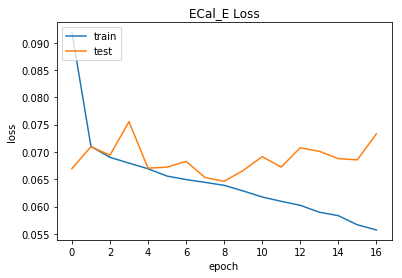

{0: 0.9968164993550959, 1: 0.9968164993550959}


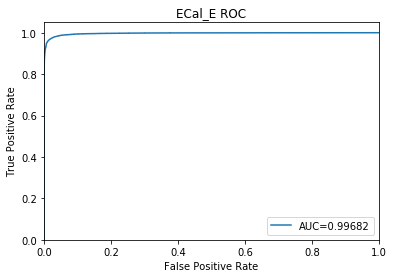


1th iteration on ee:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.1072 - val_loss: 0.0782
Epoch 2/20
151513/151513 [==============================] - 30s 198us/step - loss: 0.0699 - val_loss: 0.0719
Epoch 3/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0681 - val_loss: 0.0683
Epoch 4/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0667 - val_loss: 0.0730
Epoch 5/20
151513/151513 [==============================] - 30s 197us/step - loss: 0.0660 - val_loss: 0.0687
Epoch 6/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0647 - val_loss: 0.0693
Epoch 7/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0647 - val_loss: 0.0681
Epoch 8/20
151513/151513 [==============================] - 30s 199us/step - loss: 0.0637 - val_loss: 0.0689
Epoch 9/20
151513/151513 [=============================

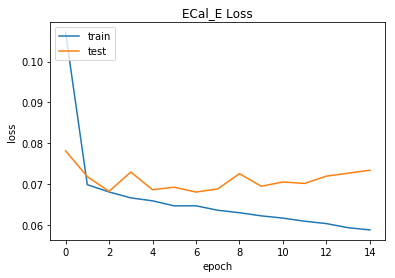

{0: 0.9970842157904275, 1: 0.9970842157904275}


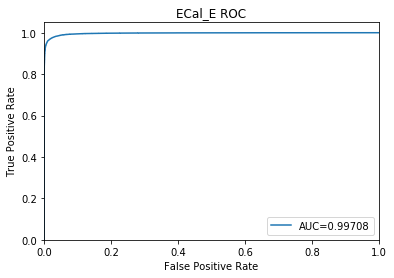


2th iteration on ee:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 30s 196us/step - loss: 4.6047 - val_loss: 0.0880
Epoch 2/20
151513/151513 [==============================] - 29s 193us/step - loss: 0.0717 - val_loss: 0.0709
Epoch 3/20
151513/151513 [==============================] - 30s 198us/step - loss: 0.0690 - val_loss: 0.0663
Epoch 4/20
151513/151513 [==============================] - 30s 198us/step - loss: 0.0670 - val_loss: 0.0699
Epoch 5/20
151513/151513 [==============================] - 30s 195us/step - loss: 0.0660 - val_loss: 0.0679
Epoch 6/20
151513/151513 [==============================] - 30s 195us/step - loss: 0.0654 - val_loss: 0.0674
Epoch 7/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0647 - val_loss: 0.0661
Epoch 8/20
151513/151513 [==============================] - 30s 197us/step - loss: 0.0635 - val_loss: 0.0681
Epoch 9/20
151513/151513 [=============================

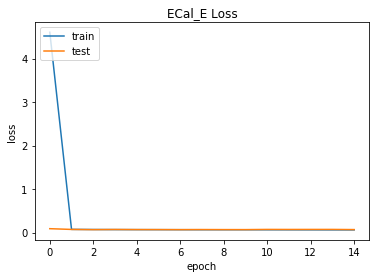

{0: 0.9969549697945614, 1: 0.9969549697945614}


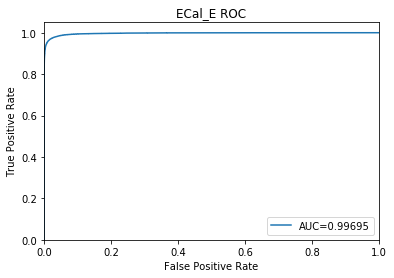


3th iteration on ee:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 30s 197us/step - loss: 8.0475 - val_loss: 8.0299
Epoch 2/20
151513/151513 [==============================] - 30s 196us/step - loss: 8.0648 - val_loss: 8.0299
Epoch 3/20
151513/151513 [==============================] - 30s 195us/step - loss: 8.0648 - val_loss: 8.0299
Epoch 4/20
151513/151513 [==============================] - 30s 197us/step - loss: 8.0648 - val_loss: 8.0299
Epoch 5/20
151513/151513 [==============================] - 30s 197us/step - loss: 8.0648 - val_loss: 8.0299
Epoch 6/20
151513/151513 [==============================] - 29s 194us/step - loss: 8.0648 - val_loss: 8.0299
Epoch 7/20
151513/151513 [==============================] - 30s 197us/step - loss: 8.0648 - val_loss: 8.0299
Epoch 8/20
151513/151513 [==============================] - 30s 195us/step - loss: 8.0648 - val_loss: 8.0299
Epoch 9/20
151513/151513 [=============================

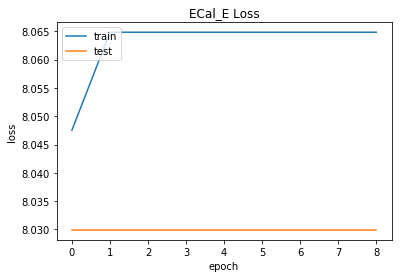

{0: 0.5, 1: 0.5}


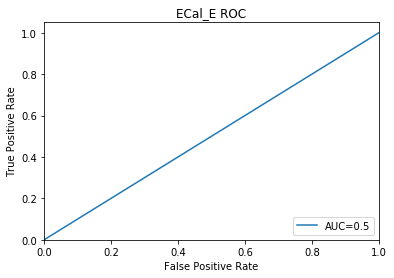


4th iteration on ee:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 30s 195us/step - loss: 0.5799 - val_loss: 0.6626
Epoch 2/20
151513/151513 [==============================] - 30s 195us/step - loss: 0.4173 - val_loss: 0.3111
Epoch 3/20
151513/151513 [==============================] - 30s 198us/step - loss: 0.3259 - val_loss: 0.2277
Epoch 4/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.2227 - val_loss: 0.1661
Epoch 5/20
151513/151513 [==============================] - 29s 195us/step - loss: 0.1504 - val_loss: 0.1299
Epoch 6/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.1181 - val_loss: 0.1056
Epoch 7/20
151513/151513 [==============================] - 30s 198us/step - loss: 0.0955 - val_loss: 0.0849
Epoch 8/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0867 - val_loss: 0.0776
Epoch 9/20
151513/151513 [=============================

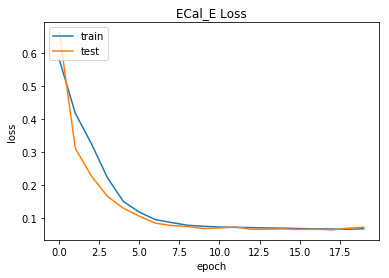

{0: 0.9969669644540216, 1: 0.9969669644540216}


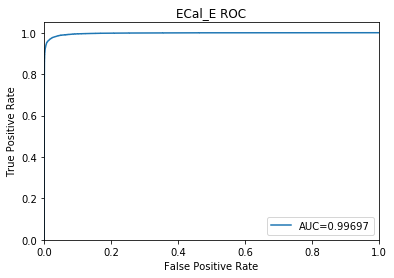


5th iteration on ee:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 29s 195us/step - loss: 8.0494 - val_loss: 8.0959
Epoch 2/20
151513/151513 [==============================] - 30s 199us/step - loss: 8.0612 - val_loss: 8.0959
Epoch 3/20
151513/151513 [==============================] - 30s 195us/step - loss: 8.0612 - val_loss: 8.0959
Epoch 4/20
151513/151513 [==============================] - 30s 196us/step - loss: 8.0612 - val_loss: 8.0959
Epoch 5/20
151513/151513 [==============================] - 30s 195us/step - loss: 8.0612 - val_loss: 8.0959
Epoch 6/20
151513/151513 [==============================] - 30s 196us/step - loss: 8.0612 - val_loss: 8.0959
Epoch 7/20
151513/151513 [==============================] - 29s 194us/step - loss: 8.0612 - val_loss: 8.0959
Epoch 8/20
151513/151513 [==============================] - 30s 198us/step - loss: 8.0612 - val_loss: 8.0959
Epoch 9/20
151513/151513 [=============================

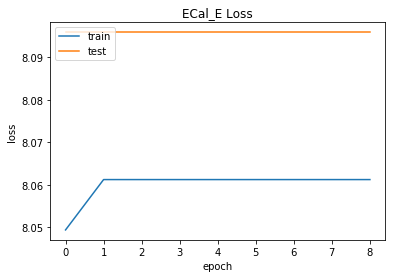

{0: 0.5, 1: 0.5}


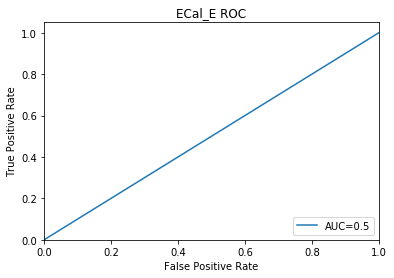


6th iteration on ee:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.3577 - val_loss: 0.1877
Epoch 2/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.1588 - val_loss: 0.1267
Epoch 3/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.1104 - val_loss: 0.0962
Epoch 4/20
151513/151513 [==============================] - 30s 197us/step - loss: 0.0896 - val_loss: 0.0832
Epoch 5/20
151513/151513 [==============================] - 30s 198us/step - loss: 0.0808 - val_loss: 0.0745
Epoch 6/20
151513/151513 [==============================] - 30s 195us/step - loss: 0.0759 - val_loss: 0.0751
Epoch 7/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0728 - val_loss: 0.0698
Epoch 8/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0705 - val_loss: 0.0723
Epoch 9/20
151513/151513 [=============================

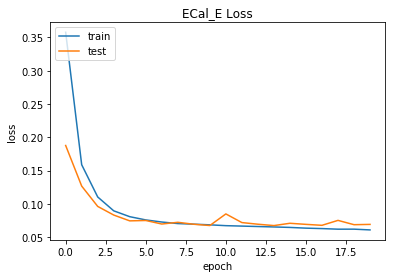

{0: 0.9967166441534598, 1: 0.9967166441534598}


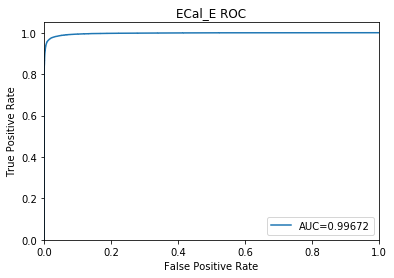


7th iteration on ee:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 30s 197us/step - loss: 0.1171 - val_loss: 0.0880
Epoch 2/20
151513/151513 [==============================] - 30s 198us/step - loss: 0.0706 - val_loss: 0.0676
Epoch 3/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0683 - val_loss: 0.0658
Epoch 4/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0671 - val_loss: 0.0649
Epoch 5/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0661 - val_loss: 0.0650
Epoch 6/20
151513/151513 [==============================] - 30s 197us/step - loss: 0.0657 - val_loss: 0.0693
Epoch 7/20
151513/151513 [==============================] - 30s 197us/step - loss: 0.0652 - val_loss: 0.0677
Epoch 8/20
151513/151513 [==============================] - 30s 196us/step - loss: 0.0639 - val_loss: 0.0660
Epoch 9/20
151513/151513 [=============================

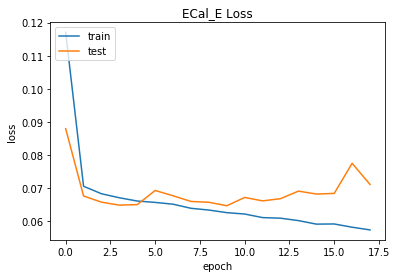

{0: 0.9970217314874774, 1: 0.9970217314874774}


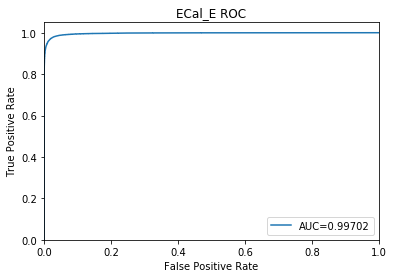


8th iteration on ee:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 30s 196us/step - loss: 8.0289 - val_loss: 8.0648
Epoch 2/20
151513/151513 [==============================] - 30s 196us/step - loss: 8.0494 - val_loss: 8.0648
Epoch 3/20
151513/151513 [==============================] - 30s 198us/step - loss: 8.0494 - val_loss: 8.0648
Epoch 4/20
151513/151513 [==============================] - 30s 199us/step - loss: 8.0494 - val_loss: 8.0648
Epoch 5/20
151513/151513 [==============================] - 30s 196us/step - loss: 8.0494 - val_loss: 8.0648
Epoch 6/20
151513/151513 [==============================] - 30s 195us/step - loss: 8.0494 - val_loss: 8.0648
Epoch 7/20
151513/151513 [==============================] - 30s 196us/step - loss: 8.0494 - val_loss: 8.0648
Epoch 8/20
151513/151513 [==============================] - 27s 176us/step - loss: 8.0494 - val_loss: 8.0648
Epoch 9/20
151513/151513 [=============================

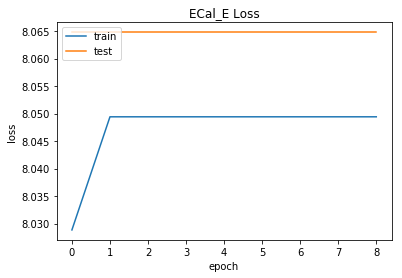

{0: 0.5, 1: 0.5}


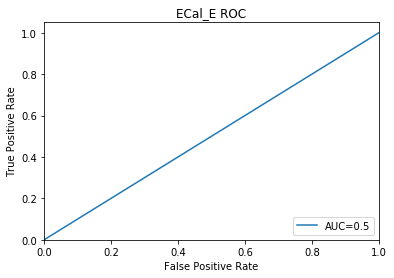


9th iteration on ee:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 26s 169us/step - loss: 0.2942 - val_loss: 0.0678
Epoch 2/20
151513/151513 [==============================] - 26s 173us/step - loss: 0.0704 - val_loss: 0.0686
Epoch 3/20
151513/151513 [==============================] - 26s 169us/step - loss: 0.0684 - val_loss: 0.0677
Epoch 4/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.0671 - val_loss: 0.0655
Epoch 5/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.0663 - val_loss: 0.0679
Epoch 6/20
151513/151513 [==============================] - 25s 164us/step - loss: 0.0654 - val_loss: 0.0698
Epoch 7/20
151513/151513 [==============================] - 25s 164us/step - loss: 0.0650 - val_loss: 0.0659
Epoch 8/20
151513/151513 [==============================] - 25s 164us/step - loss: 0.0640 - val_loss: 0.0654
Epoch 9/20
151513/151513 [=============================

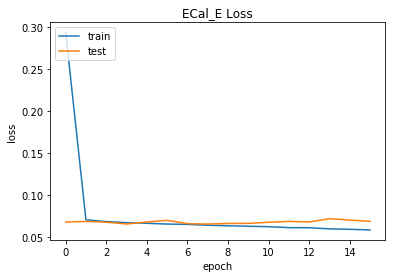

{0: 0.9971504506736029, 1: 0.9971504506736029}


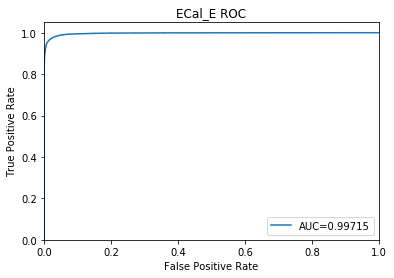

[0.9968164993550959, 0.9970842157904275, 0.9969549697945614, 0.5, 0.9969669644540216, 0.5, 0.9967166441534598, 0.9970217314874774, 0.5, 0.9971504506736029]


In [12]:
ee_aucs = run_model_Ntimes(10,model,ee_x,ee_y,"ee",p=False)
print(ee_aucs)


0th iteration on et:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.2816 - val_loss: 0.1346
Epoch 2/20
151513/151513 [==============================] - 25s 164us/step - loss: 0.1063 - val_loss: 0.0810
Epoch 3/20
151513/151513 [==============================] - 25s 165us/step - loss: 0.0717 - val_loss: 0.0647
Epoch 4/20
151513/151513 [==============================] - 25s 164us/step - loss: 0.0574 - val_loss: 0.0510
Epoch 5/20
151513/151513 [==============================] - 25s 164us/step - loss: 0.0500 - val_loss: 0.0468
Epoch 6/20
151513/151513 [==============================] - 25s 165us/step - loss: 0.0461 - val_loss: 0.0510
Epoch 7/20
151513/151513 [==============================] - 25s 164us/step - loss: 0.0436 - val_loss: 0.0410
Epoch 8/20
151513/151513 [==============================] - 25s 164us/step - loss: 0.0416 - val_loss: 0.0433
Epoch 9/20
151513/151513 [=============================

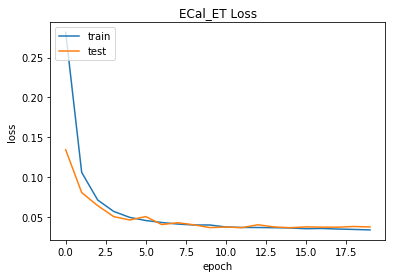

{0: 0.9985684482337828, 1: 0.9985684482337828}


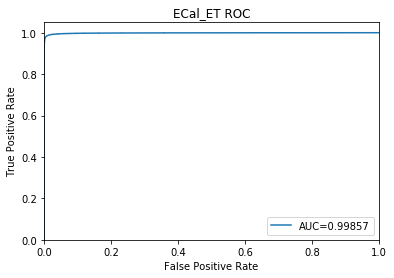


1th iteration on et:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0707 - val_loss: 0.0408
Epoch 2/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0421 - val_loss: 0.0425
Epoch 3/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.0400 - val_loss: 0.0382
Epoch 4/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0390 - val_loss: 0.0405
Epoch 5/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.0385 - val_loss: 0.0425
Epoch 6/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.0380 - val_loss: 0.0376
Epoch 7/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.0376 - val_loss: 0.0386
Epoch 8/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0374 - val_loss: 0.0380
Epoch 9/20
151513/151513 [=============================

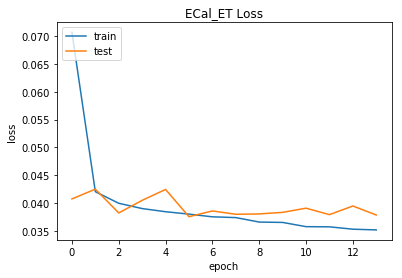

{0: 0.9987004663811386, 1: 0.9987004663811386}


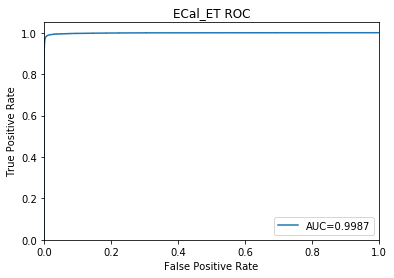


2th iteration on et:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.0728 - val_loss: 0.0392
Epoch 2/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0412 - val_loss: 0.0402
Epoch 3/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0407 - val_loss: 0.0429
Epoch 4/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0395 - val_loss: 0.0374
Epoch 5/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0387 - val_loss: 0.0381
Epoch 6/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0382 - val_loss: 0.0363
Epoch 7/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0374 - val_loss: 0.0368
Epoch 8/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0370 - val_loss: 0.0378
Epoch 9/20
151513/151513 [=============================

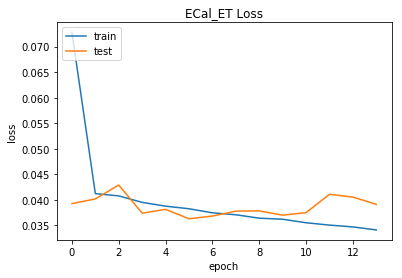

{0: 0.998652571015764, 1: 0.998652571015764}


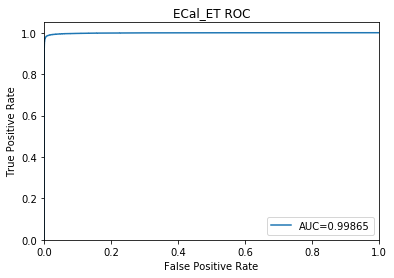


3th iteration on et:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0690 - val_loss: 0.0388
Epoch 2/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0411 - val_loss: 0.0425
Epoch 3/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.0392 - val_loss: 0.0375
Epoch 4/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0386 - val_loss: 0.0361
Epoch 5/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0374 - val_loss: 0.0360
Epoch 6/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0374 - val_loss: 0.0403
Epoch 7/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0368 - val_loss: 0.0383
Epoch 8/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0364 - val_loss: 0.0378
Epoch 9/20
151513/151513 [=============================

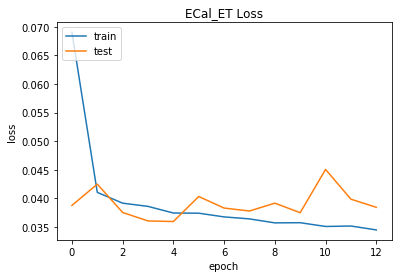

{0: 0.9984402779454208, 1: 0.9984402779454208}


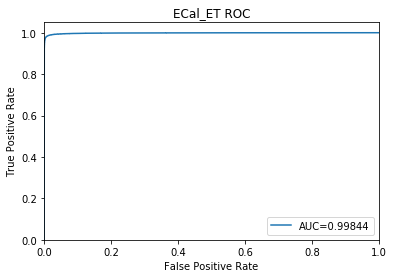


4th iteration on et:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0663 - val_loss: 0.0457
Epoch 2/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0410 - val_loss: 0.0415
Epoch 3/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0403 - val_loss: 0.0389
Epoch 4/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.0392 - val_loss: 0.0391
Epoch 5/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0384 - val_loss: 0.0402
Epoch 6/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0374 - val_loss: 0.0400
Epoch 7/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0377 - val_loss: 0.0410
Epoch 8/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.0370 - val_loss: 0.0400
Epoch 9/20
151513/151513 [=============================

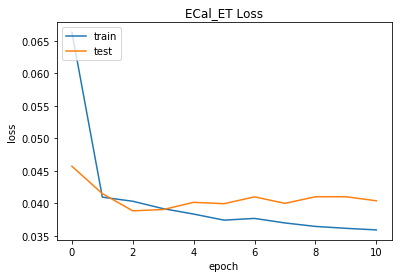

{0: 0.9986803382070035, 1: 0.9986803382070035}


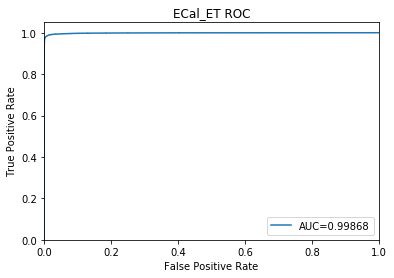


5th iteration on et:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0712 - val_loss: 0.0433
Epoch 2/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0410 - val_loss: 0.0449
Epoch 3/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.0397 - val_loss: 0.0448
Epoch 4/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0388 - val_loss: 0.0399
Epoch 5/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0378 - val_loss: 0.0402
Epoch 6/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0377 - val_loss: 0.0398
Epoch 7/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.0368 - val_loss: 0.0407
Epoch 8/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0367 - val_loss: 0.0406
Epoch 9/20
151513/151513 [=============================

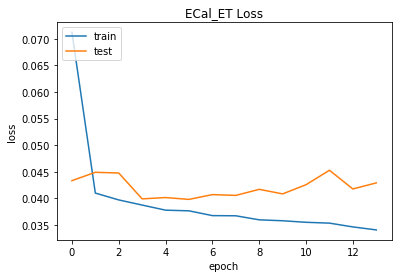

{0: 0.9986524351881757, 1: 0.9986524351881757}


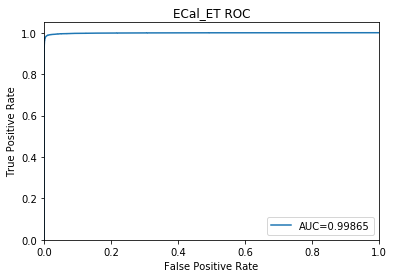


6th iteration on et:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0664 - val_loss: 0.0412
Epoch 2/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0414 - val_loss: 0.0460
Epoch 3/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0404 - val_loss: 0.0403
Epoch 4/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0388 - val_loss: 0.0399
Epoch 5/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0380 - val_loss: 0.0417
Epoch 6/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.0377 - val_loss: 0.0447
Epoch 7/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0371 - val_loss: 0.0407
Epoch 8/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0368 - val_loss: 0.0401
Epoch 9/20
151513/151513 [=============================

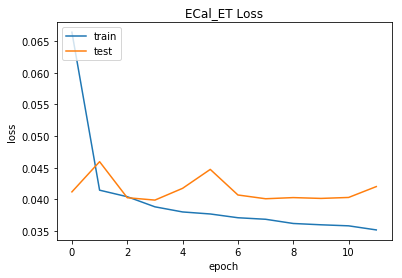

{0: 0.9986618766034763, 1: 0.9986618766034763}


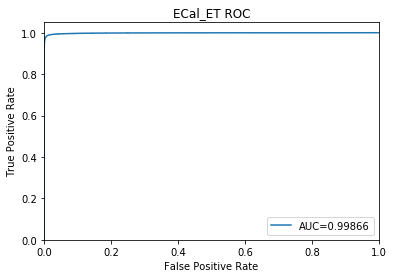


7th iteration on et:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.2294 - val_loss: 0.0514
Epoch 2/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0480 - val_loss: 0.0440
Epoch 3/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0415 - val_loss: 0.0373
Epoch 4/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0410 - val_loss: 0.0369
Epoch 5/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0403 - val_loss: 0.0424
Epoch 6/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.0393 - val_loss: 0.0357
Epoch 7/20
151513/151513 [==============================] - 28s 188us/step - loss: 0.0391 - val_loss: 0.0362
Epoch 8/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0382 - val_loss: 0.0358
Epoch 9/20
151513/151513 [=============================

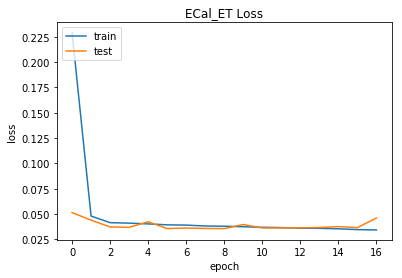

{0: 0.9986777630409456, 1: 0.9986777630409456}


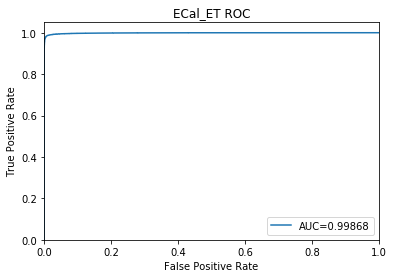


8th iteration on et:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.0713 - val_loss: 0.0425
Epoch 2/20
151513/151513 [==============================] - 28s 187us/step - loss: 0.0419 - val_loss: 0.0391
Epoch 3/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0407 - val_loss: 0.0434
Epoch 4/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.0401 - val_loss: 0.0358
Epoch 5/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.0394 - val_loss: 0.0358
Epoch 6/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0382 - val_loss: 0.0363
Epoch 7/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0379 - val_loss: 0.0355
Epoch 8/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0377 - val_loss: 0.0362
Epoch 9/20
151513/151513 [=============================

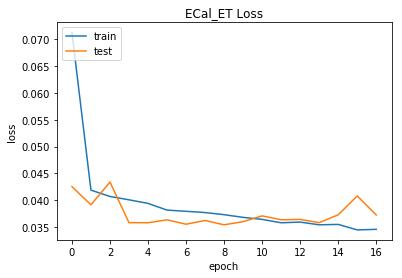

{0: 0.998657893475649, 1: 0.998657893475649}


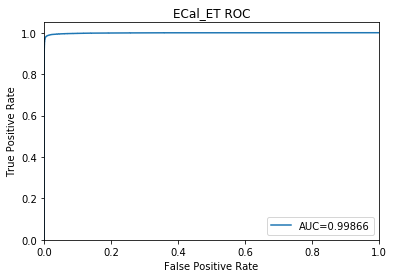


9th iteration on et:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 29s 190us/step - loss: 0.0711 - val_loss: 0.0424
Epoch 2/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0415 - val_loss: 0.0389
Epoch 3/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0393 - val_loss: 0.0376
Epoch 4/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0382 - val_loss: 0.0382
Epoch 5/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.0379 - val_loss: 0.0373
Epoch 6/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0374 - val_loss: 0.0381
Epoch 7/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.0369 - val_loss: 0.0377
Epoch 8/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.0367 - val_loss: 0.0372
Epoch 9/20
151513/151513 [=============================

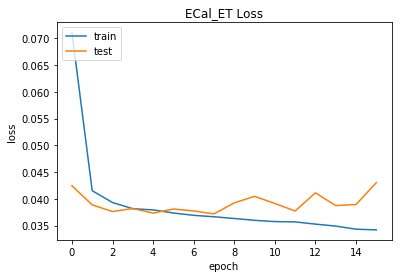

{0: 0.9986273210111922, 1: 0.9986273210111922}


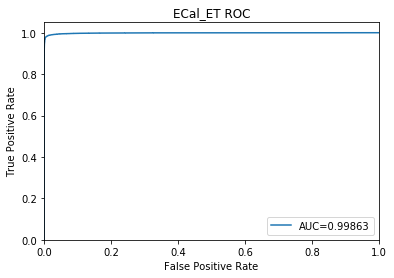

[0.9985684482337828, 0.9987004663811386, 0.998652571015764, 0.9984402779454208, 0.9986803382070035, 0.9986524351881757, 0.9986618766034763, 0.9986777630409456, 0.998657893475649, 0.9986273210111922]


In [13]:
et_aucs = run_model_Ntimes(10,model,et_x,et_y,"et",p=False)
print(et_aucs)


0th iteration on he:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3973 - val_loss: 0.3711
Epoch 2/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3683 - val_loss: 0.3671
Epoch 3/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3659 - val_loss: 0.3702
Epoch 4/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3651 - val_loss: 0.3671
Epoch 5/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3641 - val_loss: 0.3678
Epoch 6/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3638 - val_loss: 0.3656
Epoch 7/20
151513/151513 [==============================] - 28s 187us/step - loss: 0.3632 - val_loss: 0.3659
Epoch 8/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3620 - val_loss: 0.3656
Epoch 9/20
151513/151513 [=============================

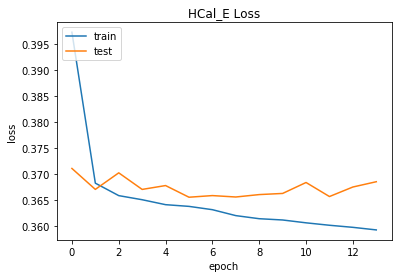

{0: 0.8896624361618078, 1: 0.8896624361618078}


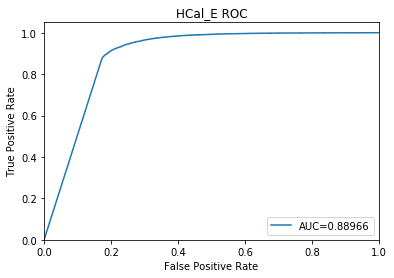


1th iteration on he:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3739 - val_loss: 0.3700
Epoch 2/20
151513/151513 [==============================] - 28s 188us/step - loss: 0.3657 - val_loss: 0.3668
Epoch 3/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3649 - val_loss: 0.3668
Epoch 4/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.3642 - val_loss: 0.3686
Epoch 5/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.3639 - val_loss: 0.3680
Epoch 6/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.3631 - val_loss: 0.3662
Epoch 7/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3630 - val_loss: 0.3671
Epoch 8/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3623 - val_loss: 0.3677
Epoch 9/20
151513/151513 [=============================

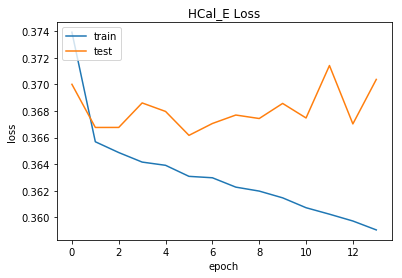

{0: 0.889981397936111, 1: 0.889981397936111}


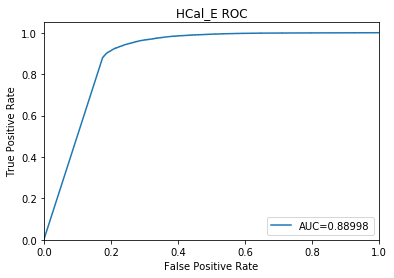


2th iteration on he:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3781 - val_loss: 0.3695
Epoch 2/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3652 - val_loss: 0.3692
Epoch 3/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3639 - val_loss: 0.3690
Epoch 4/20
151513/151513 [==============================] - 29s 188us/step - loss: 0.3633 - val_loss: 0.3679
Epoch 5/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3631 - val_loss: 0.3683
Epoch 6/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3627 - val_loss: 0.3747
Epoch 7/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3622 - val_loss: 0.3689
Epoch 8/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3619 - val_loss: 0.3696
Epoch 9/20
151513/151513 [=============================

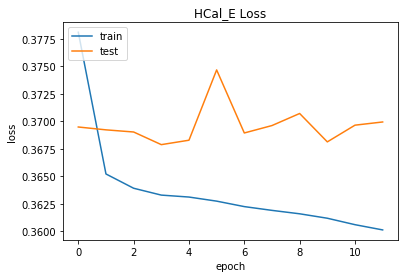

{0: 0.890792153572866, 1: 0.890792153572866}


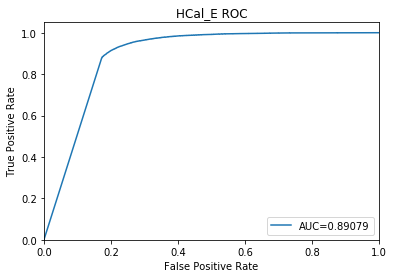


3th iteration on he:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 187us/step - loss: 0.3762 - val_loss: 0.3713
Epoch 2/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3637 - val_loss: 0.3686
Epoch 3/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3625 - val_loss: 0.3689
Epoch 4/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3620 - val_loss: 0.3686
Epoch 5/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3612 - val_loss: 0.3697
Epoch 6/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3609 - val_loss: 0.3698
Epoch 7/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3605 - val_loss: 0.3699
Epoch 8/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3599 - val_loss: 0.3705
Epoch 9/20
151513/151513 [=============================

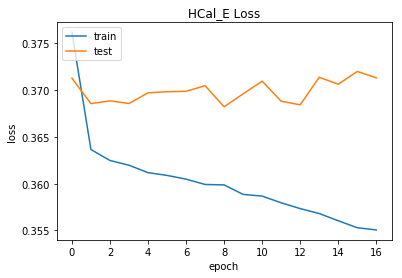

{0: 0.8875076711108973, 1: 0.8875076711108973}


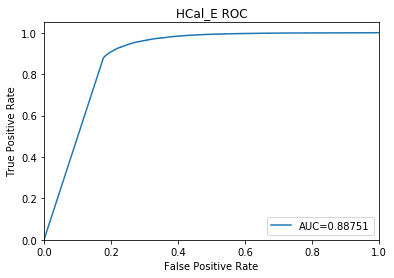


4th iteration on he:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3738 - val_loss: 0.3818
Epoch 2/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.3648 - val_loss: 0.3740
Epoch 3/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3638 - val_loss: 0.3764
Epoch 4/20
151513/151513 [==============================] - 28s 186us/step - loss: 0.3628 - val_loss: 0.3759
Epoch 5/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3628 - val_loss: 0.3745
Epoch 6/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3620 - val_loss: 0.3746
Epoch 7/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3617 - val_loss: 0.3739
Epoch 8/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.3615 - val_loss: 0.3746
Epoch 9/20
151513/151513 [=============================

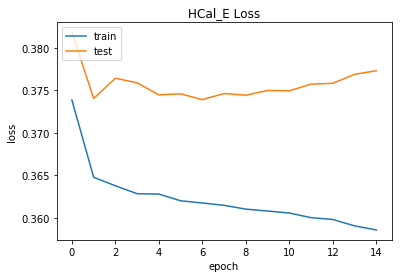

{0: 0.891793581693478, 1: 0.891793581693478}


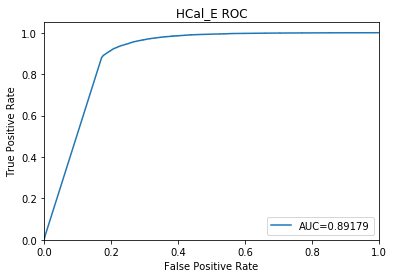


5th iteration on he:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3840 - val_loss: 0.3601
Epoch 2/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3683 - val_loss: 0.3594
Epoch 3/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3672 - val_loss: 0.3591
Epoch 4/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.3669 - val_loss: 0.3588
Epoch 5/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3662 - val_loss: 0.3582
Epoch 6/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.3658 - val_loss: 0.3608
Epoch 7/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.3655 - val_loss: 0.3582
Epoch 8/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3650 - val_loss: 0.3603
Epoch 9/20
151513/151513 [=============================

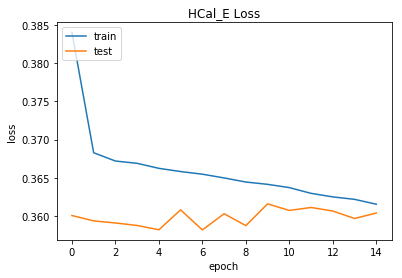

{0: 0.8905203984240146, 1: 0.8905203984240146}


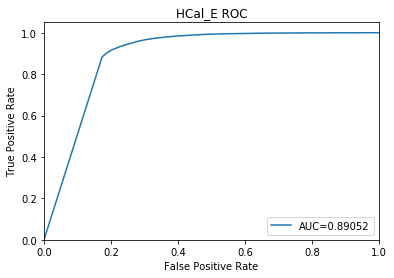


6th iteration on he:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.3752 - val_loss: 0.3693
Epoch 2/20
151513/151513 [==============================] - 27s 181us/step - loss: 0.3655 - val_loss: 0.3680
Epoch 3/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3648 - val_loss: 0.3636
Epoch 4/20
151513/151513 [==============================] - 28s 185us/step - loss: 0.3645 - val_loss: 0.3641
Epoch 5/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3637 - val_loss: 0.3661
Epoch 6/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3637 - val_loss: 0.3644
Epoch 7/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3631 - val_loss: 0.3631
Epoch 8/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3625 - val_loss: 0.3648
Epoch 9/20
151513/151513 [=============================

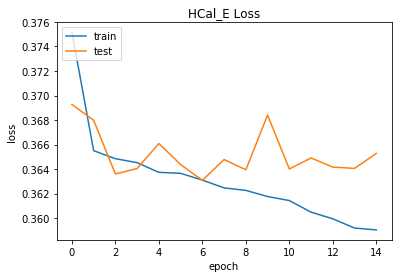

{0: 0.8881655331172054, 1: 0.8881655331172054}


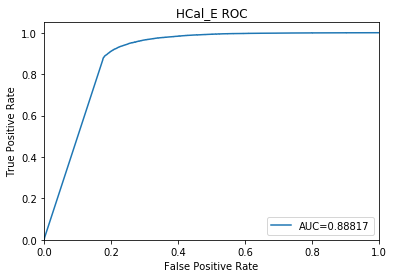


7th iteration on he:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3734 - val_loss: 0.3680
Epoch 2/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3641 - val_loss: 0.3685
Epoch 3/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3634 - val_loss: 0.3672
Epoch 4/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3627 - val_loss: 0.3675
Epoch 5/20
151513/151513 [==============================] - 28s 186us/step - loss: 0.3624 - val_loss: 0.3686
Epoch 6/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3622 - val_loss: 0.3675
Epoch 7/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3615 - val_loss: 0.3686
Epoch 8/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3612 - val_loss: 0.3670
Epoch 9/20
151513/151513 [=============================

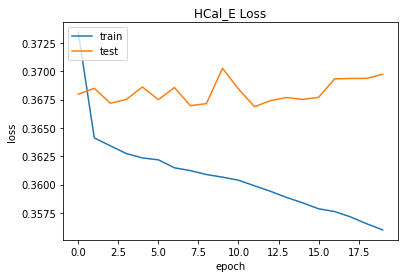

{0: 0.8880420572481564, 1: 0.8880420572481564}


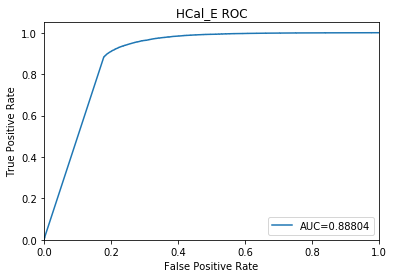


8th iteration on he:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.3717 - val_loss: 0.3707
Epoch 2/20
151513/151513 [==============================] - 28s 184us/step - loss: 0.3635 - val_loss: 0.3714
Epoch 3/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3625 - val_loss: 0.3679
Epoch 4/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.3617 - val_loss: 0.3679
Epoch 5/20
151513/151513 [==============================] - 28s 182us/step - loss: 0.3611 - val_loss: 0.3682
Epoch 6/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3610 - val_loss: 0.3688
Epoch 7/20
151513/151513 [==============================] - 29s 189us/step - loss: 0.3602 - val_loss: 0.3677
Epoch 8/20
151513/151513 [==============================] - 28s 183us/step - loss: 0.3600 - val_loss: 0.3684
Epoch 9/20
151513/151513 [=============================

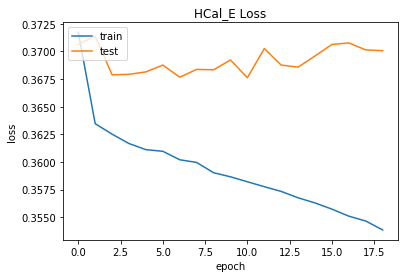

{0: 0.8876881383974392, 1: 0.8876881383974392}


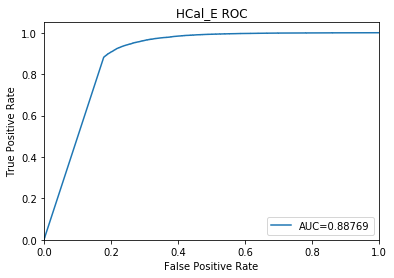


9th iteration on he:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3771 - val_loss: 0.3663
Epoch 2/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3652 - val_loss: 0.3658
Epoch 3/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3643 - val_loss: 0.3661
Epoch 4/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3632 - val_loss: 0.3647
Epoch 5/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3629 - val_loss: 0.3667
Epoch 6/20
151513/151513 [==============================] - 25s 164us/step - loss: 0.3623 - val_loss: 0.3652
Epoch 7/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3618 - val_loss: 0.3668
Epoch 8/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3616 - val_loss: 0.3655
Epoch 9/20
151513/151513 [=============================

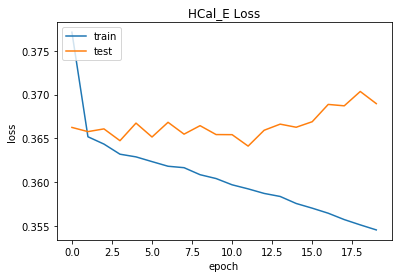

{0: 0.8877834778459232, 1: 0.8877834778459232}


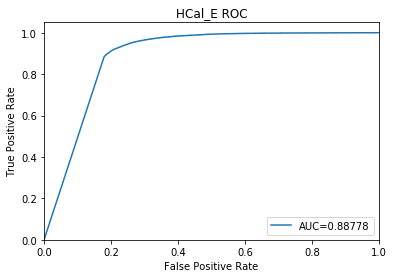

[0.8896624361618078, 0.889981397936111, 0.890792153572866, 0.8875076711108973, 0.891793581693478, 0.8905203984240146, 0.8881655331172054, 0.8880420572481564, 0.8876881383974392, 0.8877834778459232]


In [14]:
he_aucs = run_model_Ntimes(10,model,he_x,he_y,"he",p=False)
print(he_aucs)


0th iteration on ht:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3607 - val_loss: 0.3563
Epoch 2/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3518 - val_loss: 0.3552
Epoch 3/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3516 - val_loss: 0.3529
Epoch 4/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3510 - val_loss: 0.3524
Epoch 5/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3506 - val_loss: 0.3533
Epoch 6/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3505 - val_loss: 0.3529
Epoch 7/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3502 - val_loss: 0.3541
Epoch 8/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3499 - val_loss: 0.3535
Epoch 9/20
151513/151513 [=============================

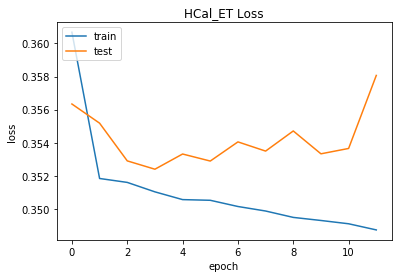

{0: 0.8899368117026122, 1: 0.8899368117026122}


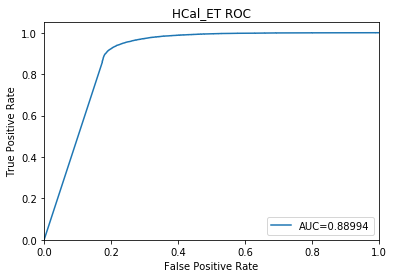


1th iteration on ht:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3648 - val_loss: 0.3475
Epoch 2/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3546 - val_loss: 0.3469
Epoch 3/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3544 - val_loss: 0.3504
Epoch 4/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3539 - val_loss: 0.3504
Epoch 5/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3536 - val_loss: 0.3466
Epoch 6/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3532 - val_loss: 0.3467
Epoch 7/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3531 - val_loss: 0.3465
Epoch 8/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3530 - val_loss: 0.3472
Epoch 9/20
151513/151513 [=============================

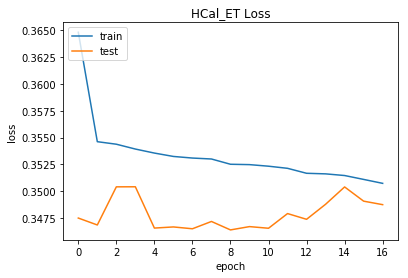

{0: 0.8930769476105314, 1: 0.8930769476105314}


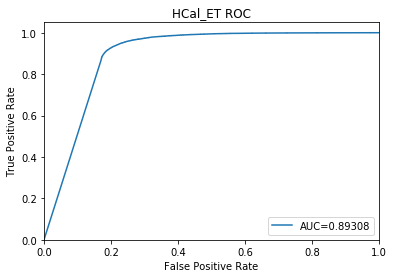


2th iteration on ht:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3646 - val_loss: 0.3493
Epoch 2/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3530 - val_loss: 0.3488
Epoch 3/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3523 - val_loss: 0.3489
Epoch 4/20
151513/151513 [==============================] - 25s 164us/step - loss: 0.3520 - val_loss: 0.3493
Epoch 5/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3517 - val_loss: 0.3481
Epoch 6/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3513 - val_loss: 0.3471
Epoch 7/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3511 - val_loss: 0.3478
Epoch 8/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3511 - val_loss: 0.3483
Epoch 9/20
151513/151513 [=============================

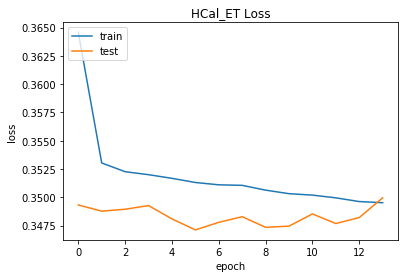

{0: 0.8904573734544967, 1: 0.8904573734544967}


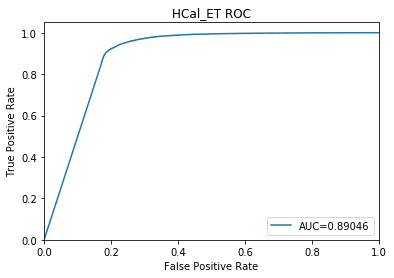


3th iteration on ht:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 25s 165us/step - loss: 0.3625 - val_loss: 0.3587
Epoch 2/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3534 - val_loss: 0.3515
Epoch 3/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3528 - val_loss: 0.3531
Epoch 4/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3525 - val_loss: 0.3526
Epoch 5/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3520 - val_loss: 0.3526
Epoch 6/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3519 - val_loss: 0.3522
Epoch 7/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3517 - val_loss: 0.3517
Epoch 8/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3512 - val_loss: 0.3519
Epoch 9/20
151513/151513 [=============================

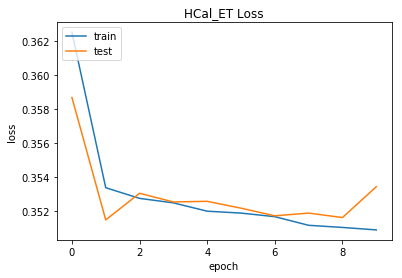

{0: 0.892165859213598, 1: 0.892165859213598}


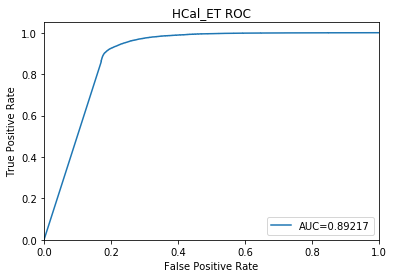


4th iteration on ht:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3633 - val_loss: 0.3535
Epoch 2/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3526 - val_loss: 0.3532
Epoch 3/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3523 - val_loss: 0.3531
Epoch 4/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3519 - val_loss: 0.3597
Epoch 5/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3516 - val_loss: 0.3524
Epoch 6/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3514 - val_loss: 0.3544
Epoch 7/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3511 - val_loss: 0.3538
Epoch 8/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3509 - val_loss: 0.3530
Epoch 9/20
151513/151513 [=============================

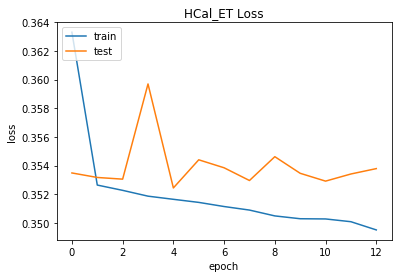

{0: 0.8924055405307811, 1: 0.8924055405307811}


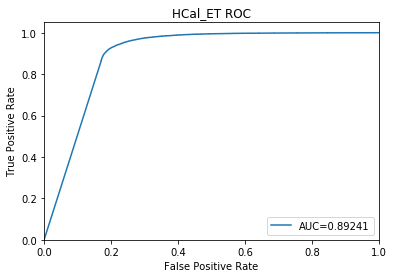


5th iteration on ht:
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3611 - val_loss: 0.3526
Epoch 2/20
151513/151513 [==============================] - 24s 161us/step - loss: 0.3529 - val_loss: 0.3520
Epoch 3/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3527 - val_loss: 0.3517
Epoch 4/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3518 - val_loss: 0.3563
Epoch 5/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3518 - val_loss: 0.3514
Epoch 6/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3511 - val_loss: 0.3525
Epoch 7/20
151513/151513 [==============================] - 25s 162us/step - loss: 0.3510 - val_loss: 0.3517
Epoch 8/20
151513/151513 [==============================] - 25s 163us/step - loss: 0.3504 - val_loss: 0.3525
Epoch 9/20
151513/151513 [=============================

In [ ]:
ht_aucs = run_model_Ntimes(10,model,ht_x,ht_y,"ht",p=False)
print(ht_aucs)

In [ ]:
print("Done")